## Libraries

In [221]:
# libraries
import numpy as np
import matplotlib.pylab as plt
import scipy.constants as cs

## Semiconductor data

In [222]:
# data for several semiconductors
data = {'Si':{'Eg':1.14,'m_c':0.36,'m_v':0.81,'e_s':11.7},
        'Ge':{'Eg':0.67,'m_c':0.55,'m_v':0.37,'e_s':15.8},
        'GaN':{'Eg':3.34,'m_c':0.2,'m_v':1.4,'e_s':9.7},
        'GaP':{'Eg':2.26,'m_c':0.79,'m_v':0.83,'e_s':10.8},
        'GaAs':{'Eg':1.42,'m_c':0.067,'m_v':0.45,'e_s':12.95},
        'CdS':{'Eg':2.42,'m_c':0.18,'m_v':0.53,'e_s':9.0},
        'CdSe':{'Eg':1.74,'m_c':0.13,'m_v':0.3,'e_s':10.0},
        'CdTe':{'Eg':1.49,'m_c':0.11,'m_v':0.35,'e_s':9.6},
        'ZnSe':{'Eg':2.7,'m_c':0.17,'m_v':1.44,'e_s':9.0},
        'ZnS':{'Eg':3.54,'m_c':0.28,'m_v':1.40,'e_s':8.2},
        'ZnO':{'Eg':3.37,'m_c':0.29,'m_v':1.21,'e_s':9.0},}


## Inputs

In [223]:
# inputs
T = 300 # temperature in kelvin
x_min,x_max,x_step = -500,500,1000 # x coordinate in nm
v_x = np.linspace(x_min,x_max,x_step)*1e-9
v_x_sig = np.linspace(-5,5,x_step)
N_A, N_D = 3e16, 1e16 # doping levels
el = 'Si' # chosen element
Js = 1e-13

## Functions

In [224]:
def f_gc(element,E):
    """
        Calculates the density of states in the conduction band for a given element and energy.

        Args:
            element (str): Name of the semiconductor element.
            E (float): Energy level (eV).

        Returns:
            float: Density of states in the conduction band (cm^-3 eV^-1).

        Uses the following physical constants from the 'cs' module:
            * elementary_charge (e)
            * Boltzmann constant (k_B)
            * electron mass (m_e)
            * reduced Planck constant (hbar)

        Extracts the following semiconductor parameters from the 'data' dictionary:
            * Band gap energy (Eg) for the given element
            * Effective mass in the conduction band (m_c) relative to the electron mass
            * Effective mass in the valence band (m_v) relative to the electron mass

        The density of states is calculated using the following equation:
            gc = ((m_c / (np.pi**2 * hbar**2)) * np.sqrt(2 * (E - 0.5 * E_g) * m_c / hbar**2)
        """

    # physical constants
    e = cs.elementary_charge
    k_B = cs.Boltzmann / e
    m_e = cs.electron_mass
    hbar = cs.hbar / e

    # semiconductor params
    E_g = data[element]['Eg']
    m_c = m_e * data[element]['m_c']
    m_v = m_e * data[element]['m_v']

    # compute density of states
    if E>0.5*E_g:
        gc = ((m_c)/((np.pi**2)*(hbar**2)))*np.sqrt((2*(E-0.5*E_g)*m_c)/(hbar**2))
    else:
        gc=0.0

    return gc

def f_gv(element,E):
    """
    Calculates the density of states in the valence band for a given element and energy.

    Args:
        element (str): Name of the semiconductor element.
        E (float): Energy level (eV).

    Returns:
        float: Density of states in the valence band (cm^-3 eV^-1).

    Uses the same physical constants and semiconductor parameters as `f_gc`.

    The density of states is calculated using the following equation:
        gv = ((m_v / (np.pi**2 * hbar**2)) * np.sqrt(2 * (0.5 * E_g - E) * m_v / hbar**2)
    """

    # physical constants
    e = cs.elementary_charge
    k_B = cs.Boltzmann / e
    m_e = cs.electron_mass
    hbar = cs.hbar / e

    # semiconductor params
    E_g = data[element]['Eg']
    m_c = m_e * data[element]['m_c']
    m_v = m_e * data[element]['m_v']

    # compute density of states
    if -0.5*E_g>E:
        gv = ((m_v)/((np.pi**2)*(hbar**2)))*np.sqrt((2*(-0.5*E_g-E)*m_v)/(hbar**2))
    else:
        gv=0.0

    return gv

In [225]:
def f_n_i(element,T=300):
    """
    Calculates the intrinsic carrier concentration in a semiconductor.

    This function calculates the intrinsic carrier concentration (n_i) in a 
    semiconductor material based on its element symbol and temperature.

    Args:
        Element (str): Symbol of the semiconductor element.
        T (float, optional): Temperature of the semiconductor in Kelvin. 
            Defaults to 300 K.

    Returns:
        float: Intrinsic carrier concentration (n_i) in cm^-3.

    Raises:
        KeyError: If the provided element symbol is not found in the 
                 data dictionary.

    Uses constants from the 'scipy.constants' (cs) module:
        * k_B: Boltzmann constant
        * e: Elementary charge
        * m_e: Electron mass
        * hbar: Reduced Planck constant
    """

    # physical constants
    e = cs.elementary_charge
    k_B = cs.Boltzmann
    m_e = cs.electron_mass
    hbar = cs.hbar
    
    # semiconductor params
    E_g = data[element]['Eg'] * e 
    m_c = m_e * data[element]['m_c']
    m_v = m_e * data[element]['m_v']

    N_c = 0.25*((2 * m_c * k_B * T)/(np.pi*hbar**2))**(3.0/2.0)
    P_v = 0.25*((2 * m_v * k_B * T)/(np.pi*hbar**2))**(3.0/2.0)

    n_i = np.sqrt(N_c*P_v)*np.exp(-E_g/(2.0*k_B*T))/1e6

    return n_i

In [226]:
def f_Ef(element,doping,da_flag='D',T=300):

    """
    Calculates the Fermi energy level (E_f) in a semiconductor.

    Args:
        element (str): Name of the semiconductor element.
        doping (float): Doping concentration (cm^-3).
        da_flag (str, optional): Acceptor/Donor flag ('A' for acceptor, 'D' for donor). Defaults to 'D'.
        T (float, optional): Temperature (K). Defaults to 300.

    Returns:
        float: The Fermi energy level (E_f) in eV.

    Raises:
        ValueError: If da_flag is not 'A' or 'D'.

    Uses the following constants from the 'cs' module:
        e: elementary charge (C)
        k_B: Boltzmann constant (eV/K)
        m_e: electron mass (kg)
        hbar: reduced Planck constant (eV*s)

    Requires the following data from a source (not provided here):
        data[element]: Dictionary containing semiconductor parameters for the given element.
            - 'Eg': band gap energy (eV)
            - 'm_c': effective mass of conduction band (m_e)
            - 'm_v': effective mass of valence band (m_e)

    This function calculates the Fermi energy level based on the doping concentration,
    temperature, and acceptor/donor flag. It uses the intrinsic carrier concentration
    obtained from the `f_n_i` function (assumed to be defined elsewhere).
    """

    # physical constants
    e = cs.elementary_charge
    k_B = cs.Boltzmann / e
    m_e = cs.electron_mass
    hbar = cs.hbar / e
    
    # semiconductor params
    E_g = data[element]['Eg']
    m_c = m_e * data[element]['m_c']
    m_v = m_e * data[element]['m_v']

    # compute intrinsic carrier concentration
    n_i = f_n_i(element,T=T)

    # Fermi energy level
    if da_flag == 'D':
        E_f = 0.75*k_B*T*np.log(m_v/m_c) + k_B*T*np.log(doping/n_i)
    else:
        E_f = 0.75*k_B*T*np.log(m_v/m_c) - k_B*T*np.log(doping/n_i)

    return E_f

In [227]:
def fd(E,Ef,T=300):
    """Calculates the Fermi-Dirac distribution function.

    This function calculates the Fermi-Dirac distribution function, which describes
    the probability of finding a fermion in a state with energy E at temperature T.

    Args:
        E: The energy of the state (eV).
        Ef: The Fermi energy (eV).
        T: The temperature (K).

    Returns:
        The Fermi-Dirac distribution function at energy E.
    """

    # constants
    k_B = cs.Boltzmann/cs.elementary_charge

    return 1.0/(1.0 + np.exp((E-Ef)/(k_B*T)))

In [228]:
def f_V0(element,T=300.0,N_A=1e16,N_D=1e16):
    """
    Calculates the built-in potential (V0) for a given element.

    Args:
        element (str): Name of the element for which V0 is calculated.
        T (float, optional): Temperature in Kelvin. Defaults to 300.0.
        N_A (float, optional): Acceptor concentration (cm^-3). Defaults to 1e16.
        N_D (float, optional): Donor concentration (cm^-3). Defaults to 1e16.

    Returns:
        float: The built-in potential (V0) in volts.

    Raises:
        NotImplementedError: If the provided element is not supported.

    Requires:
        constant_service (module): Provides access to physical constants.
        f_n_i (function): Calculates the intrinsic carrier concentration for a given element and temperature.

    Notes:
        This function assumes the Boltzmann constant (k_B) and elementary charge (e) are accessible
        from the `constant_service` module. The function `f_n_i` is assumed to be available
        and calculates the intrinsic carrier concentration.
    """    

    # physical constants
    e = cs.elementary_charge
    k_B = cs.Boltzmann

    # built in potential
    V0 = (k_B*T/e) * np.log(N_A*N_D/f_n_i(element,T)**2)

    return V0


In [229]:
def f_depletion(element,N_A=1e16,N_D=1e16):
    """
    Calculates the depletion widths in a semiconductor element.

    This function calculates the depletion width on both sides of a p-n
    junction in a semiconductor element. It assumes abrupt junctions.

    Args:
        element (str): The element symbol of the semiconductor material.
        N_A (float, optional): The doping concentration of acceptors (cm^-3).
            Defaults to 1e16.
        N_D (float, optional): The doping concentration of donors (cm^-3).
            Defaults to 1e16.

    Returns:
        tuple: A tuple containing three floats, representing the total depletion
            width (x_0), the depletion width in the p-type region (x_p), and the
            depletion width in the n-type region (x_n), all in meters.
    """
    
    # physical constants
    e = cs.elementary_charge
    e_0 = cs.epsilon_0
    e_s = data[element]['e_s']

    # built in potential
    V0 = f_V0(element,N_A=N_A,N_D=N_D)

    # rescale doping to S.I.
    N_A = N_A*1e6
    N_D = N_D*1e6

    # depletion widths
    x_0 = np.sqrt( (2.0*e_s*e_0*V0/e) * ( (N_A+N_D)/(N_A*N_D) ) )
    x_n = np.sqrt( (2.0*e_s*e_0*V0/e) * ( N_A/(N_D*(N_A+N_D)) ) )
    x_p = np.sqrt( (2.0*e_s*e_0*V0/e) * ( N_D/(N_A*(N_A+N_D)) ) )

    return x_0,x_p,x_n

In [230]:
def f_rho(x,element,N_A=1e16,N_D=1e16):
    """
    Calculates the net charge density (rho) in a one-dimensional semiconductor 
    device at a given position (x).

    Args:
        x (float): The position (in meters) within the device.
        element (str): The element symbol of the semiconductor material.
        N_A (float, optional): The acceptor doping concentration (in cm^-3). 
            Defaults to 1e16.
        N_D (float, optional): The donor doping concentration (in cm^-3). 
            Defaults to 1e16.

    Returns:
        float: The net charge density (in C/m^3) at position x.

    Raises:
        NotImplementedError: If the element is not supported.

    Notes:
        This function assumes a simple abrupt junction model.
        The built-in potential (V0) and depletion region widths (x_0, x_p, x_n) 
        are calculated using external functions `f_V0` and `f_depletion`.
        The doping concentrations are rescaled to SI units (m^-3) before use.
    """
    
    # physical constants
    e = cs.elementary_charge

    # built in potential
    V0 = f_V0(element,N_A=N_A,N_D=N_D)

    # depletion regions
    x_0,x_p,x_n =f_depletion('Si',N_A=N_A,N_D=N_D)

    # rescale doping to S.I.
    N_A = N_A*1e6
    N_D = N_D*1e6

    # field computation
    if x<-x_p:
        rho = 0
    elif x>-x_p and x<0:
        rho = -e*N_A
    elif x>=0 and x<x_n:
        rho = e*N_D
    elif x>=x_n:
        rho=0

    return rho

In [231]:
def f_E_bi(x,element,N_A=1e16,N_D=1e16):
    """
    Calculates the electric field (E-field) within a p-n junction diode 
    under equilibrium conditions.

    This function computes the E-field profile for a given position (x) 
    within a silicon (Si) p-n junction considering built-in potential (V0), 
    depletion region widths, and doping concentrations (N_A, N_D).

    Args:
        x (float): The position within the device (m). 
            Positive values correspond to the n-type region, 
            negative values to the p-type region.
        element (str): Material element symbol.
        e_s (float, optional): Semiconductor relative permittivity (default 11.7).
        N_A (float, optional): Acceptor doping concentration (cm^-3, default 1e16).
        N_D (float, optional): Donor doping concentration (cm^-3, default 1e16).

    Returns:
        float: The electric field (V/m) at the specified position (x).
    """

    # physical constants
    e = cs.elementary_charge
    e_0 = cs.epsilon_0
    e_s = data[element]['e_s']

    # built in potential
    V0 = f_V0(element,N_A=N_A,N_D=N_D)

    # depletion regions
    x_0,x_p,x_n =f_depletion('Si',N_A=N_A,N_D=N_D)

    # rescale doping to S.I.
    N_A = N_A*1e6
    N_D = N_D*1e6

    # field computation
    if x<-x_p:
        E = 0
    elif x>-x_p and x<0:
        E = -(e*N_A/(e_s*e_0))*(x+x_p)
    elif x>=0 and x<x_n:
        E = (e*N_D/(e_s*e_0))*(x-x_n)
    elif x>=x_n:
        E=0

    return E        

In [232]:
def f_V_bi(x,element,N_A=1e16,N_D=1e16):
    """
    Calculates the built-in potential (V_bi) in a semiconductor device.

    This function calculates the built-in potential (V_bi) within a 
    semiconductor device based on the position (x), element type, 
    acceptor doping concentration (N_A), donor doping concentration (N_D), 
    elementary charge (e), permittivity of free space (epsilon_0), and 
    relative permittivity (e_s).

    Args:
        x (float): The position within the device (m).
        element (str): The element symbol of the semiconductor material.
        e_s (float, optional): Semiconductor relative permittivity. Defaults to 11.7.
        N_A (float, optional): The acceptor doping concentration (cm^-3). Defaults to 1e16.
        N_D (float, optional): The donor doping concentration (cm^-3). Defaults to 1e16.

    Returns:
        float: The built-in potential (V_bi) in volts (V).

    Raises:
        NotImplementedError: If the provided element is not supported.
    """

    # physical constants
    e = cs.elementary_charge
    e_0 = cs.epsilon_0
    e_s = data[element]['e_s']

    # built in potential
    V0 = f_V0(element,N_A=N_A,N_D=N_D)

    # depletion regions
    x_0,x_p,x_n =f_depletion('Si',N_A=N_A,N_D=N_D)

    # rescale doping to S.I.
    N_A = N_A*1e6
    N_D = N_D*1e6

    # voltage computation
    if x<-x_p:
        V = 0
    elif x>-x_p and x<0:
        V = (e*N_A/(2.0*e_s*e_0))*(x+x_p)**2
    elif x>=0 and x<x_n:
        V=(e/(2.0*e_s*e_0))*(N_A*x_p**2 + N_D*x_n**2) - (e*N_D/(2.0*e_s*e_0))*(x-x_n)**2
    elif x>=x_n:
        V=(e/(2.0*e_s*e_0))*(N_A*x_p**2 + N_D*x_n**2)

    return V

In [233]:
def f_J(V,Js=Js,T=300.0):

    # physical constants
    e = cs.elementary_charge
    k_B = cs.Boltzmann
    m_e = cs.electron_mass

    return Js*(np.exp(e*V/(k_B*T))-1)

## Performing the calculations

In [234]:
v_rho = np.array([f_rho(x,el,N_A=N_A,N_D=N_D) for x in v_x])/1e3
v_E = np.array([f_E_bi(x,el,N_A=N_A,N_D=N_D) for x in v_x])/1e6
v_V = np.array([f_V_bi(x,el,N_A=N_A,N_D=N_D) for x in v_x])
x_0,x_p,x_n = f_depletion(el,N_A=N_A,N_D=N_D)

# fake data for sigmoid band plot
v_V_eq = 1.5-1.0/(1.0+np.exp(v_x_sig))
v_V_forward = 0.5-0.5/(1.0+np.exp(v_x_sig))
v_V_reverse = 2.5-2.5/(1.0+np.exp(v_x_sig))

# compute I-V for pn junction
V_min,V_max, V_step = -0.25,0.5,1000
v_V_pn = np.linspace(V_min,V_max,V_step)
v_J = np.array([f_J(V) for V in v_V_pn])

In [235]:
print(1e9*x_p,1e9*x_n)

93.51266433033106 280.5379929909932


In [236]:
f_V0('Si',T=300.0,N_A=1e16,N_D=1e16)

0.7830601658746396

In [237]:
f_n_i('GaAs')/1e6

2.1456676733420896

## Plots

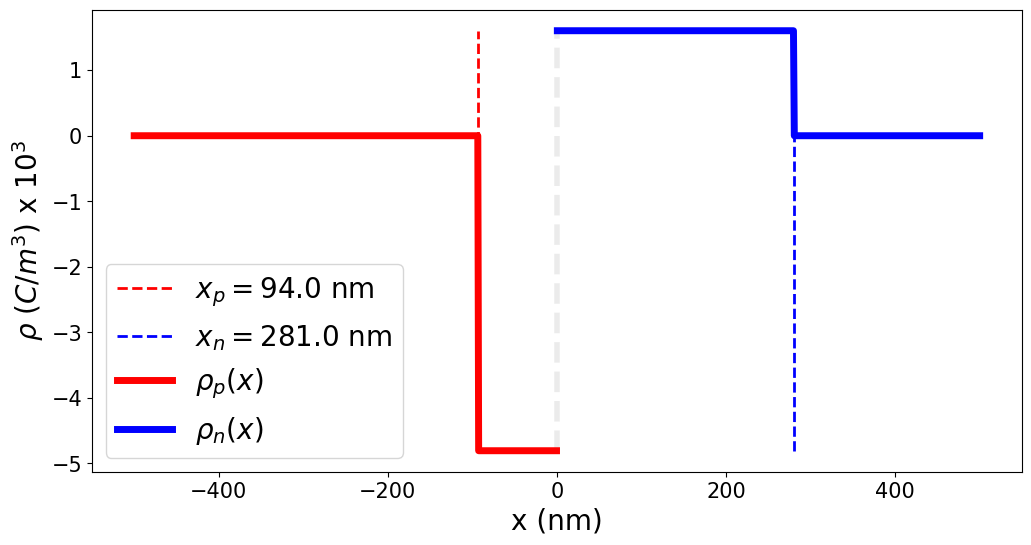

In [238]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
ax.vlines(-x_p*1e9,v_rho.min(),v_rho.max(),linewidth=2.0,linestyle='dashed',color='red',label=r'$x_p=$'+str(np.round(1e9*x_p))+ ' nm')
ax.vlines(x_n*1e9,v_rho.min(),v_rho.max(),linewidth=2.0,linestyle='dashed',color='blue',label=r'$x_n=$'+str(np.round(1e9*x_n))+ ' nm')
ax.vlines(0,v_rho.min(),v_rho.max(),linewidth=4.0,linestyle='dashed',color='0.7',alpha=0.25)

# normalized electron density
ax.plot(v_x[v_x<0]*1e9,v_rho[v_x<0],linewidth=5.0,color='red',label=r'$\rho_p(x)$')
ax.plot(v_x[v_x>=0]*1e9,v_rho[v_x>=0],linewidth=5.0,color='blue',label=r'$\rho_n(x)$')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel(r'$\rho$ ($C/m^3$) x $10^3$', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size)

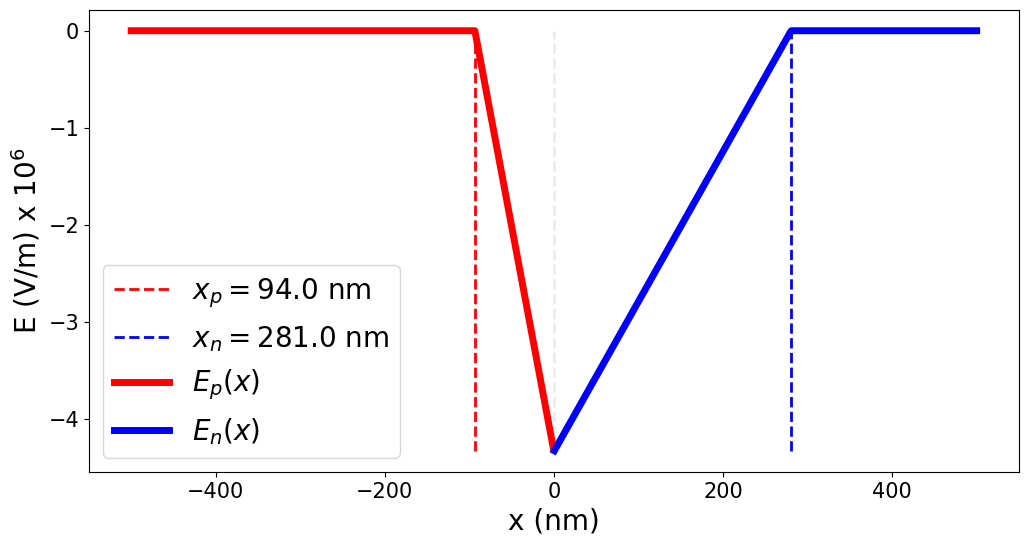

In [239]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
ax.vlines(-x_p*1e9,v_E.min(),v_E.max(),linewidth=2.0,linestyle='dashed',color='red',label=r'$x_p=$'+str(np.round(1e9*x_p))+ ' nm')
ax.vlines(x_n*1e9,v_E.min(),v_E.max(),linewidth=2.0,linestyle='dashed',color='blue',label=r'$x_n=$'+str(np.round(1e9*x_n))+ ' nm')
ax.vlines(0,v_E.min(),v_E.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)

# normalized electron density
ax.plot(v_x[v_x<0]*1e9,v_E[v_x<0],linewidth=5.0,color='red',label=r'$E_p(x)$')
ax.plot(v_x[v_x>=0]*1e9,v_E[v_x>=0],linewidth=5.0,color='blue',label=r'$E_n(x)$')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel('E (V/m) x $10^6$', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size)

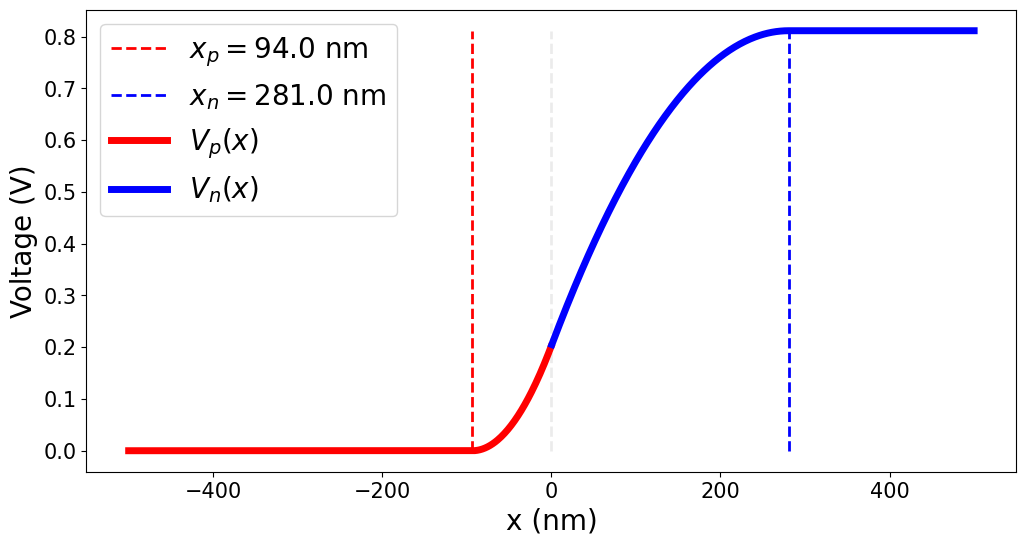

In [240]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
ax.vlines(-x_p*1e9,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='red',label=r'$x_p=$'+str(np.round(1e9*x_p))+ ' nm')
ax.vlines(x_n*1e9,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='blue',label=r'$x_n=$'+str(np.round(1e9*x_n))+ ' nm')
ax.vlines(0,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)

# normalized electron density
ax.plot(v_x[v_x<0]*1e9,v_V[v_x<0],linewidth=5.0,color='red',label=r'$V_p(x)$')
ax.plot(v_x[v_x>=0]*1e9,v_V[v_x>=0],linewidth=5.0,color='blue',label=r'$V_n(x)$')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel('Voltage (V)', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size)

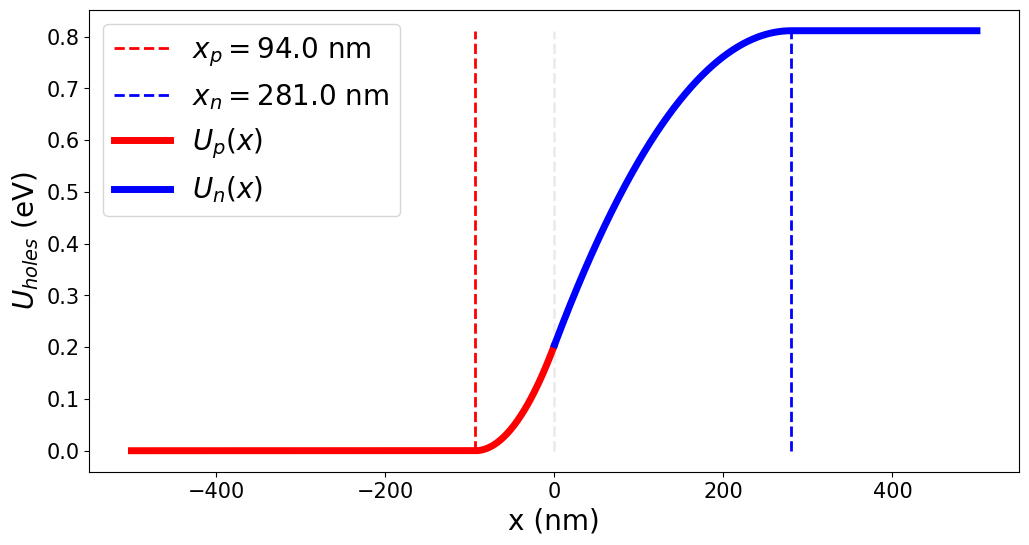

In [241]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
ax.vlines(-x_p*1e9,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='red',label=r'$x_p=$'+str(np.round(1e9*x_p))+ ' nm')
ax.vlines(x_n*1e9,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='blue',label=r'$x_n=$'+str(np.round(1e9*x_n))+ ' nm')
ax.vlines(0,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)

# normalized electron density
ax.plot(v_x[v_x<0]*1e9,v_V[v_x<0],linewidth=5.0,color='red',label=r'$U_p(x)$')
ax.plot(v_x[v_x>=0]*1e9,v_V[v_x>=0],linewidth=5.0,color='blue',label=r'$U_n(x)$')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel(r'$U_{holes}$ (eV)', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size)

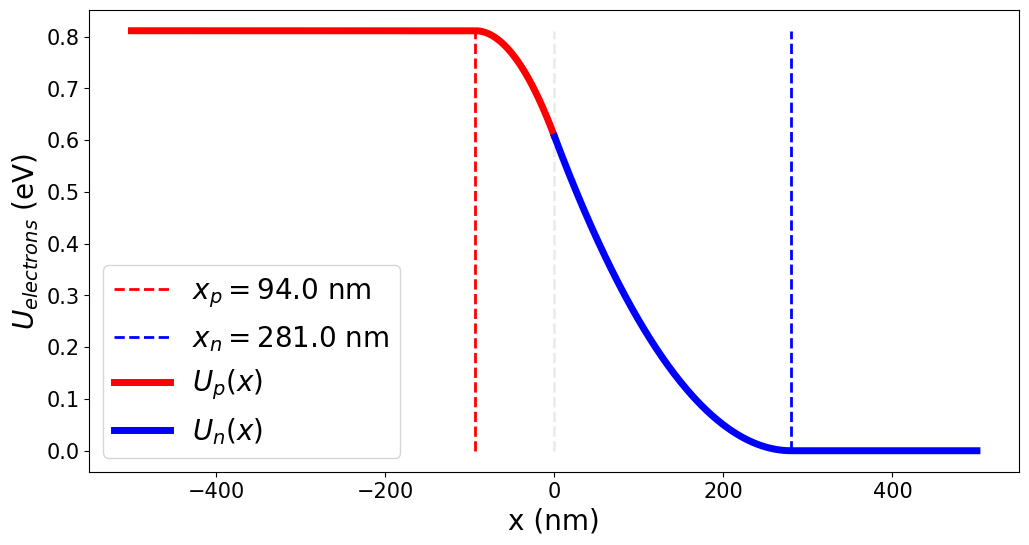

In [242]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
ax.vlines(-x_p*1e9,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='red',label=r'$x_p=$'+str(np.round(1e9*x_p))+ ' nm')
ax.vlines(x_n*1e9,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='blue',label=r'$x_n=$'+str(np.round(1e9*x_n))+ ' nm')
ax.vlines(0,v_V.min(),v_V.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)

# normalized electron density
ax.plot(v_x[v_x<0]*1e9,-v_V[v_x<0]+v_V.max(),linewidth=5.0,color='red',label=r'$U_p(x)$')
ax.plot(v_x[v_x>=0]*1e9,-v_V[v_x>=0]+v_V.max(),linewidth=5.0,color='blue',label=r'$U_n(x)$')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel(r'$U_{electrons}$ (eV)', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size,loc='lower left')

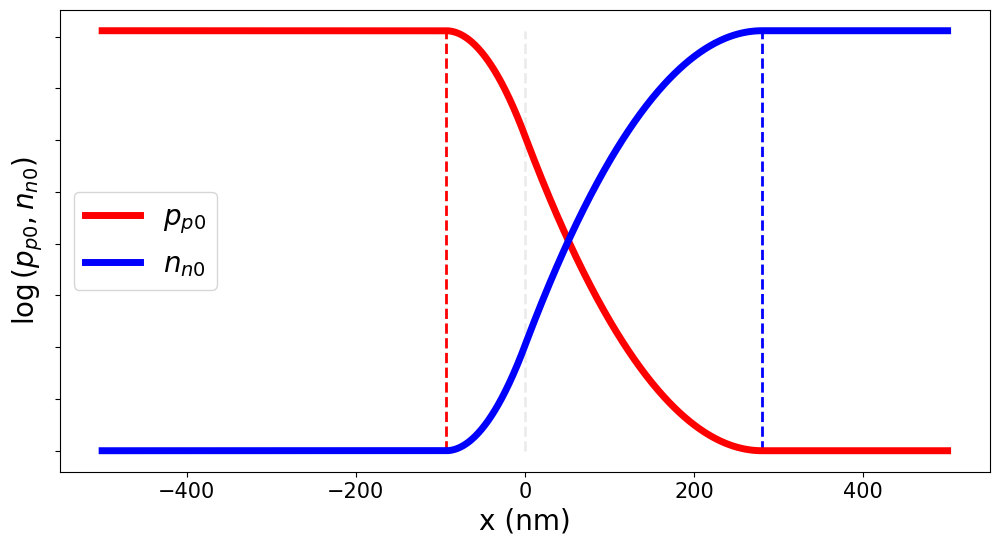

In [243]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
ax.vlines(-x_p*1e9,v_V.min(),1*v_V.max(),linewidth=2.0,linestyle='dashed',color='red')
ax.vlines(x_n*1e9,v_V.min(),1*v_V.max(),linewidth=2.0,linestyle='dashed',color='blue')
ax.vlines(0,v_V.min(),1*v_V.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)

# normalized electron density
ax.plot(v_x*1e9,-v_V+v_V.max(),linewidth=5.0,color='red',label=r'$p_{p0}$')
ax.plot(v_x*1e9,v_V,linewidth=5.0,color='blue',label=r'$n_{n0}$')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
ax.set_yticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel(r'$\log\left(p_{p0},n_{n0}\right)$', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size,loc='center left')

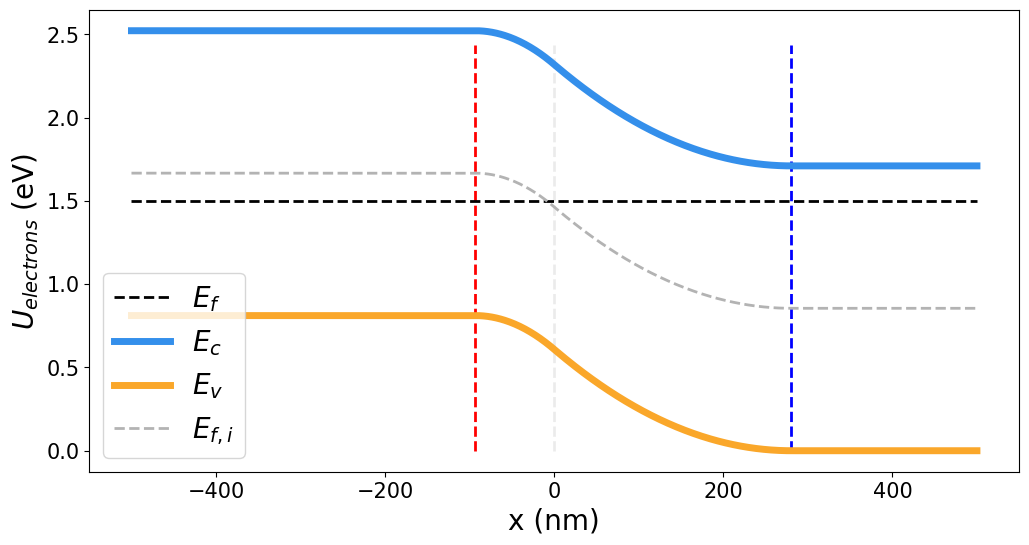

In [244]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
ax.vlines(-x_p*1e9,v_V.min(),3*v_V.max(),linewidth=2.0,linestyle='dashed',color='red')
ax.vlines(x_n*1e9,v_V.min(),3*v_V.max(),linewidth=2.0,linestyle='dashed',color='blue')
ax.vlines(0,v_V.min(),3*v_V.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)
ax.hlines(1.5,1e9*v_x.min(),1e9*v_x.max(),linewidth=2.0,linestyle='dashed',color='0.0',label='$E_{f}$')

# normalized electron density
ax.plot(v_x*1e9,-v_V+v_V.max()+1.5*data[el]['Eg'],linewidth=5.0,color='#348feb',label=r'$E_c$')
ax.plot(v_x*1e9,-v_V+v_V.max(),linewidth=5.0,color='#faa72a',label=r'$E_v$')
ax.plot(v_x*1e9,-v_V+v_V.max()+0.75*data[el]['Eg'],linewidth=2.0,color='0.7',label=r'$E_{f,i}$',linestyle='dashed')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel(r'$U_{electrons}$ (eV)', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size,loc='lower left')

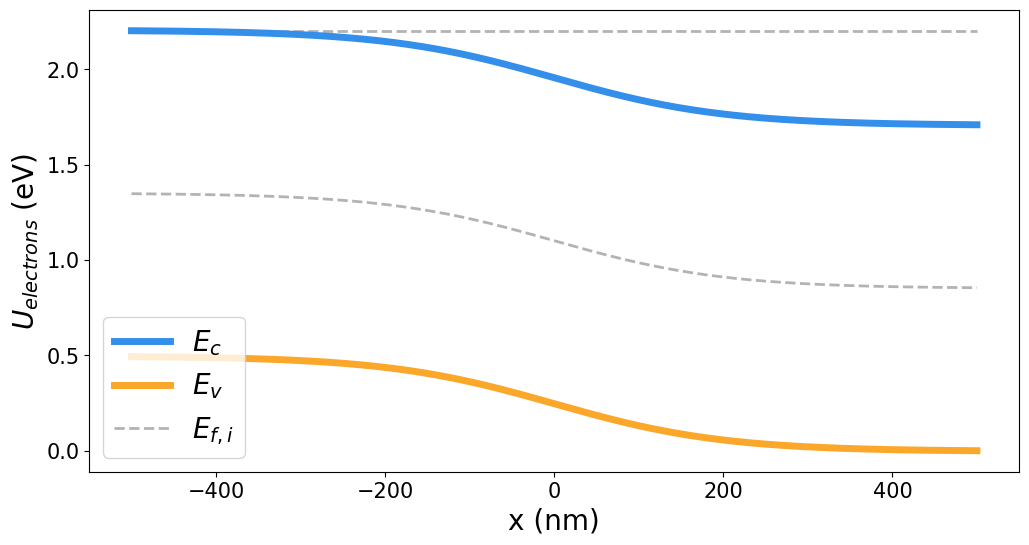

In [245]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
# ax.vlines(-x_p*1e9,v_V_small.min(),4*v_V_small.max(),linewidth=2.0,linestyle='dashed',color='red')
# ax.vlines(x_n*1e9,v_V_small.min(),4*v_V_small.max(),linewidth=2.0,linestyle='dashed',color='blue')
# ax.vlines(0,v_V_small.min(),4*v_V_small.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)
ax.hlines(-v_V_forward.min()+v_V_forward.max()+1.5*data[el]['Eg'],1e9*v_x.min(),1e9*v_x.max(),linewidth=2.0,linestyle='dashed',color='0.7')

# normalized electron density
ax.plot(v_x*1e9,-v_V_forward+v_V_forward.max()+1.5*data[el]['Eg'],linewidth=5.0,color='#348feb',label=r'$E_c$')
ax.plot(v_x*1e9,-v_V_forward+v_V_forward.max(),linewidth=5.0,color='#faa72a',label=r'$E_v$')
ax.plot(v_x*1e9,-v_V_forward+v_V_forward.max()+0.75*data[el]['Eg'],linewidth=2.0,color='0.7',label=r'$E_{f,i}$',linestyle='dashed')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel(r'$U_{electrons}$ (eV)', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size,loc='lower left')

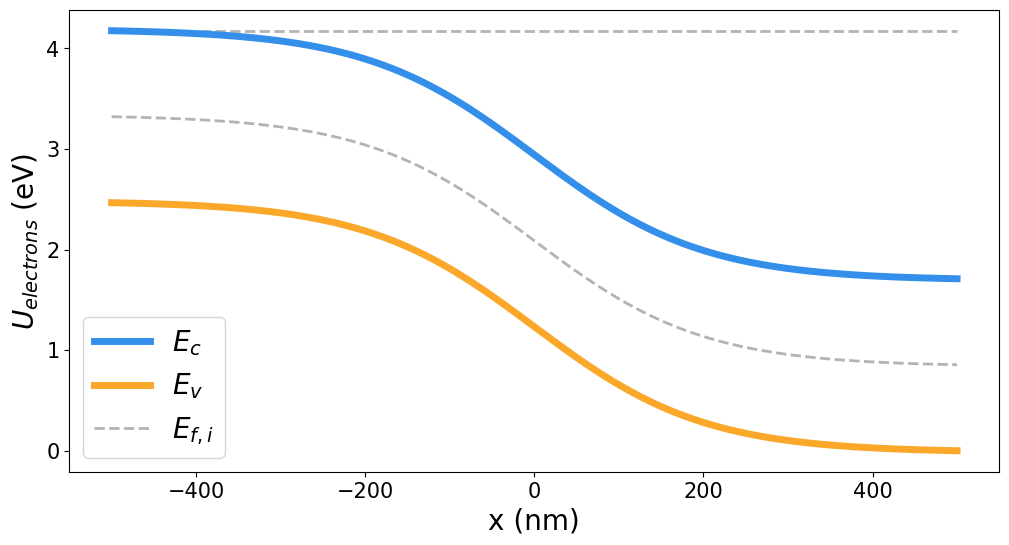

In [246]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
# ax.vlines(-x_p*1e9,v_V_big.min(),3*v_V_big.max(),linewidth=2.0,linestyle='dashed',color='red')
# ax.vlines(x_n*1e9,v_V_big.min(),3*v_V_big.max(),linewidth=2.0,linestyle='dashed',color='blue')
# ax.vlines(0,v_V_big.min(),3*v_V_big.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)
ax.hlines(-v_V_reverse.min()+v_V_reverse.max()+1.5*data[el]['Eg'],1e9*v_x.min(),1e9*v_x.max(),linewidth=2.0,linestyle='dashed',color='0.7')

# normalized electron density
ax.plot(v_x*1e9,-v_V_reverse+v_V_reverse.max()+1.5*data[el]['Eg'],linewidth=5.0,color='#348feb',label=r'$E_c$')
ax.plot(v_x*1e9,-v_V_reverse+v_V_reverse.max(),linewidth=5.0,color='#faa72a',label=r'$E_v$')
ax.plot(v_x*1e9,-v_V_reverse+v_V_reverse.max()+0.75*data[el]['Eg'],linewidth=2.0,color='0.7',label=r'$E_{f,i}$',linestyle='dashed')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel(r'$U_{electrons}$ (eV)', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size,loc='lower left')

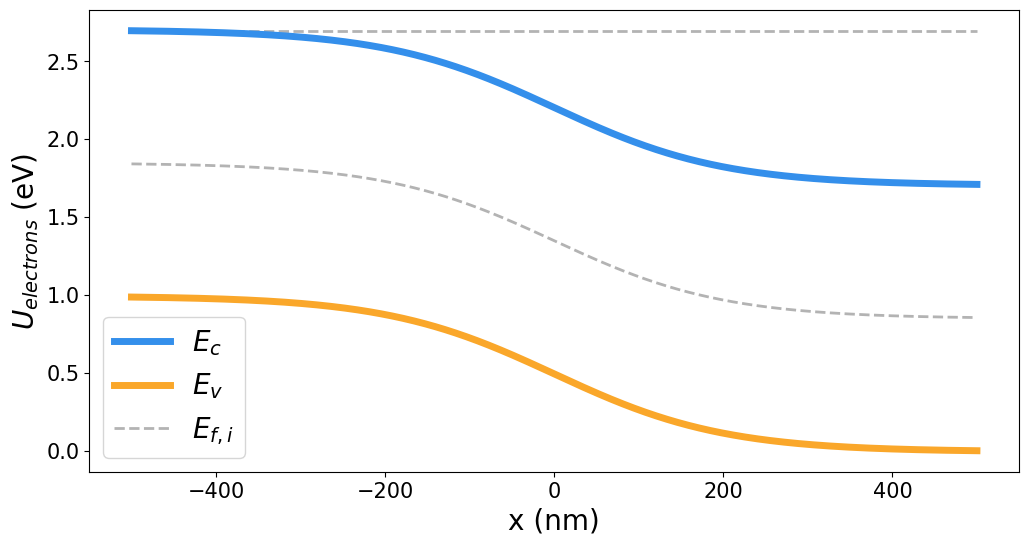

In [247]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

# depletion region lines
# ax.vlines(-x_p*1e9,v_V_small.min(),4*v_V_small.max(),linewidth=2.0,linestyle='dashed',color='red')
# ax.vlines(x_n*1e9,v_V_small.min(),4*v_V_small.max(),linewidth=2.0,linestyle='dashed',color='blue')
# ax.vlines(0,v_V_small.min(),4*v_V_small.max(),linewidth=2.0,linestyle='dashed',color='0.7',alpha=0.25)
ax.hlines(-v_V_eq.min()+v_V_eq.max()+1.5*data[el]['Eg'],1e9*v_x.min(),1e9*v_x.max(),linewidth=2.0,linestyle='dashed',color='0.7')

# normalized electron density
ax.plot(1e9*v_x,-v_V_eq+v_V_eq.max()+1.5*data[el]['Eg'],linewidth=5.0,color='#348feb',label=r'$E_c$')
ax.plot(1e9*v_x,-v_V_eq+v_V_eq.max(),linewidth=5.0,color='#faa72a',label=r'$E_v$')
ax.plot(1e9*v_x,-v_V_eq+v_V_eq.max()+0.75*data[el]['Eg'],linewidth=2.0,color='0.7',label=r'$E_{f,i}$',linestyle='dashed')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('x (nm)', fontsize=f_size)
ax.set_ylabel(r'$U_{electrons}$ (eV)', fontsize=f_size)
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size,loc='lower left')

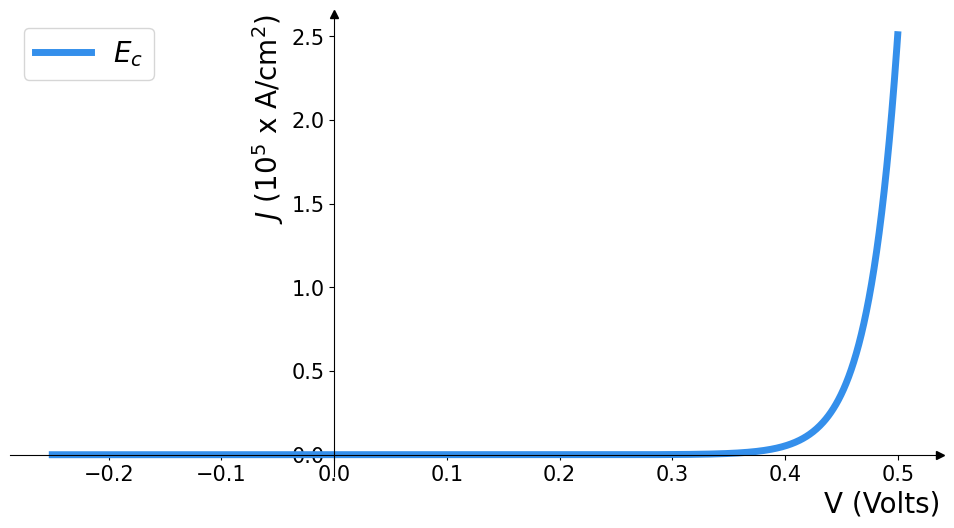

In [254]:
fig, ax = plt.subplots(figsize=(12,6))
f_size = 20

ax.spines[["left", "bottom"]].set_position(("data", 0))
# Hide the top and right spines.
ax.spines[["top", "right"]].set_visible(False)

# Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
# case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
# respectively) and the other one (1) is an axes coordinate (i.e., at the very
# right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
# actually spills out of the axes.
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

# normalized electron density
ax.plot(v_V_pn,1e5*v_J,linewidth=5.0,color='#348feb',label=r'$E_c$')

#limits
# ax.set_xlim(-0.01,1.01)
# ax.set_ylim(-1,1)

# labels
# ax.set_xticklabels([])
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xlabel('V (Volts)', fontsize=f_size,loc='right')
ax.set_ylabel(r'$J$ ($10^5$ x A/cm$^2$)', fontsize=f_size,loc='top')
ax.tick_params(labelsize=f_size-5)

# legend
ax.legend(fontsize=f_size,loc='upper left')